In [18]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import vectorbt.optimizer.gridsearch as grids

# data

In [2]:
from importlib import reload
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 5)
from matplotlib import pyplot as plt

In [59]:
ohlc_df = vbt.data.load_cryptopair('USDT_ETH', vbt.data.ago_dt(days=180), vbt.data.now_dt())

done. 2.84s


In [60]:
# No future data
rate_sr = ohlc_df.O

     count        mean       std         min         25%         50%    75%  \
O  51840.0  285.104791  50.31764  138.232765  254.637497  295.512235  314.0   

     max  
O  405.0  


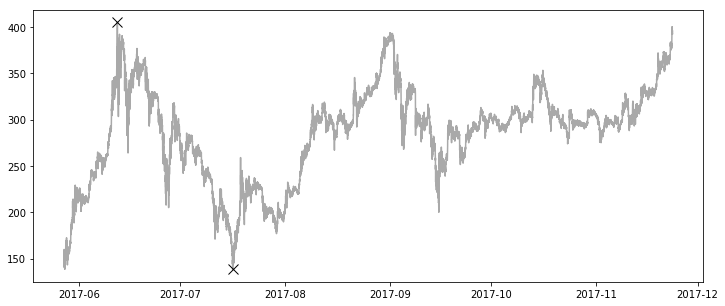

In [61]:
vbt.graphics.plot_line(rate_sr)

# number of positions

In [62]:
fees = 0.0025

In [63]:
# Func
def random_eqdfunc(n):
    v = vbt.signals.random_vector(rate_sr, n)
    idx = np.flatnonzero(v)
    entries = vbt.vector.from_idx(len(rate_sr.index), idx[0::2])
    exits = vbt.vector.from_idx(len(rate_sr.index), idx[1::2])
    pos_sr = vbt.positions.from_vectors(rate_sr, entries, exits)
    posret_sr = vbt.returns.from_positions(rate_sr, pos_sr, fees)
    eqd_sr = vbt.equity.diffs(posret_sr)
    return eqd_sr

# Params
param_range = list(range(2, 1000, 2)) * 100

In [64]:
random_eqdmap = grids.seriesmap.from_func(random_eqdfunc, param_range)

cores: 4
processes: 3
starmap: False
calcs: 49900 (~213.50s) ..
done. 190.44s


In [68]:
random_exp_sr = grids.nummap.from_seriesmap(random_eqdmap, vbt.performance.profit)

cores: 4
processes: 3
starmap: False
calcs: 49900 (~2.94s) ..
done. 30.09s
min 96: -0.744454827958
max 230: 5.26601556067


In [69]:
random_exp_df = random_exp_sr.groupby(random_exp_sr.index).describe()

     count      mean       std       min       25%       50%      75%  \
50%  499.0  0.008694  0.199901 -0.302642 -0.162174 -0.037247  0.17469   

          max  
50%  0.561434  


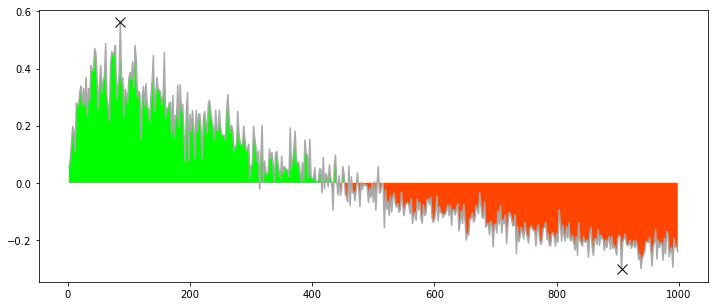

In [71]:
vbt.graphics.plot_line(random_exp_df['50%'], 0)